# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-0.112064,True,5.220841
1,1.949906,True,8.532389
2,2.502305,True,10.021414
3,-1.307156,False,-1.401723
4,-0.099585,False,0.346729
...,...,...,...
995,0.005676,False,-0.671941
996,1.130487,False,2.285188
997,1.311628,True,9.229311
998,0.548912,False,0.702911


<Axes: xlabel='v0'>

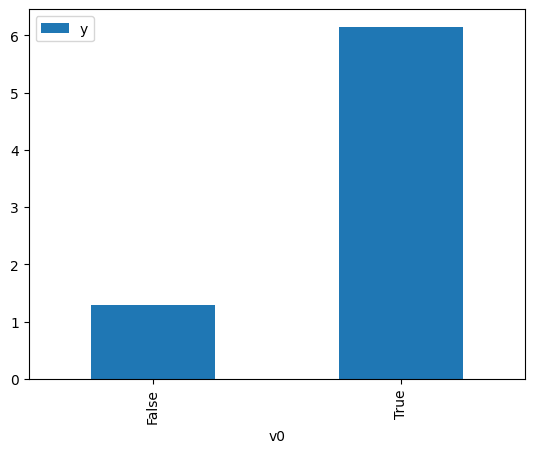

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

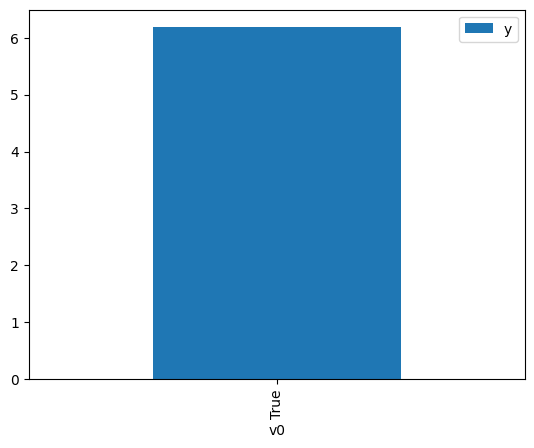

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,0.306975,False,-0.590687,0.353156,2.831608
1,0.504155,False,1.454017,0.287443,3.478951
2,-0.993235,False,-0.354176,0.800661,1.248968
3,1.447080,False,2.844579,0.086663,11.539016
4,-0.218217,False,-1.229685,0.550056,1.817997
...,...,...,...,...,...
995,1.807109,False,2.328812,0.051776,19.314144
996,-0.352251,False,-1.634337,0.600277,1.665898
997,0.258576,False,1.015085,0.370305,2.700477
998,1.830442,False,4.380673,0.050045,19.981925


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,1.228348,True,5.612718,0.882815,1.132740
1,0.018046,True,5.127563,0.540345,1.850669
2,-0.025965,True,3.676939,0.523528,1.910117
3,-0.382141,True,3.359665,0.388768,2.572231
4,2.343626,True,9.435862,0.976596,1.023965
...,...,...,...,...,...
995,1.138270,True,7.755902,0.867738,1.152421
996,0.483885,True,4.650067,0.706143,1.416144
997,0.825522,True,6.169357,0.802356,1.246329
998,0.504575,True,7.109065,0.712689,1.403136


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                          1.652e+04
Date:                Fri, 17 Nov 2023   Prob (F-statistic):                        0.00
Time:                        17:51:41   Log-Likelihood:                         -1409.6
No. Observations:                1000   AIC:                                      2823.
Df Residuals:                     998   BIC:                                      2833.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.8181      0.037     48.756      0.000       1.745       1.891
x2             4.8792      0.052     93.330      0.000       4.777       4.982
==============================================================================
Omnibus:                        5.944   Durbin-Watson:                   1.833
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                4.486
Skew:                           0.021   Prob(JB):                        0.106
Kurtosis:                       2.675   Cond. No.                         2.52
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""